<a href="https://colab.research.google.com/github/patel-zeel/Nonstat-exps/blob/main/gp_extra/GP_Extra_LLS_self_implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings
* randomness - fixed   
* optimizer - scipy
*    use of alpha and L (Cholesky) 
* not optimized lot

### Trainable parameters
1. sigma_f   
1. sigma_n   
1. l_bar   
1. sigma_l_bar

### Updates or Notes over previous update
pinv converted to alpha and L

In [93]:
from IPython.display import clear_output
!pip -qq install pods
import pods
data = pods.datasets.olympic_marathon_men()
clear_output()

In [94]:
!pip install scikit-learn
clear_output(wait=True)
print()

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RBF, WhiteKernel
from sklearn.metrics import mean_squared_error
from gp_extras.kernels import LocalLengthScalesKernel
from sklearn.preprocessing import StandardScaler
import scipy
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

## Self defined class

In [102]:
## Terminology is consistent with paper 
# Paper name: Nonstationary Gaussian Process Regression Using Point Estimates of Local Smoothness

class LLS:
  def __init__(self, N=1): # N = Number of local points
    self.N = N
    self.name = 'LLS'
    self.flag = 1 # for debugging

  def rbf(self, x1, x2, sigma_l_bar): # RBF for GP_l without variance or noise
    return np.exp(-np.square(x1-x2.T)/(2*(sigma_l_bar**2)))

  def K(self, x1, x2, sigma_f, sigma_n, lx1, lx2): # Main kernel function by Generalizing Eq. 7
    lx1sqr = np.square(lx1)
    lx2sqr = np.square(lx2)
    P_rc = lx1sqr@lx2sqr.T
    P_s = 0.5 * (lx1sqr + lx2sqr.T)
    E = np.exp(-np.square(x1-x2.T) / P_s)

    return ((sigma_f**2)*(np.sqrt(np.sqrt(P_rc)))/(np.sqrt(P_s)))*E
  
  def K_(self, x1, x2): # Main kernel function (fitted)
    lx1sqr = np.square(self.predict_lengthscales(x1, self.sigma_l_bar, self.l_bar))
    lx2sqr = np.square(self.predict_lengthscales(x2, self.sigma_l_bar, self.l_bar))
    P_rc = lx1sqr@lx2sqr.T
    P_s = 0.5 * (lx1sqr + lx2sqr.T)
    E = np.exp(-np.square(x1-x2.T) / P_s)

    return (self.sigma_f**2)*(np.sqrt(np.sqrt(P_rc)))/(np.sqrt(P_s))*E
  
  def predict_lengthscales(self, X_hat, sigma_l_bar, l_bar):
    self.K_X_barX_bar = self.rbf(self.X_bar, self.X_bar, sigma_l_bar)
    K_XX_bar = self.rbf(X_hat, self.X_bar, sigma_l_bar)
    self.L_bar = np.linalg.cholesky(self.K_X_barX_bar)
    alpha = scipy.linalg.cho_solve((self.L_bar, True), np.log(l_bar))
    l = np.exp(K_XX_bar@alpha)
    return l

  def objective(self, params): # From equation 6 in section 4.1
    sigma_f = params[0]
    sigma_n = params[1]
    l_bar = np.array(params[2:-1]).reshape(-1,1)
    sigma_l_bar = params[-1]

    # exponent of predictive mean of lengthscales for entire X
    l = self.predict_lengthscales(self.X, sigma_l_bar, l_bar) # shape of (X, X_bar)@(X_bar, X_bar)@(X_bar, 1) = (X, 1)

    # Evaluating global kernel
    K_XX = self.K(self.X, self.X, sigma_f, sigma_n, l, l) + (sigma_n**2)*np.eye(self.X.shape[0])
    self.L = np.linalg.cholesky(K_XX)
    self.alpha = scipy.linalg.cho_solve((self.L, True), self.y)
    
    L_theta =  0.5*(self.y.T@self.alpha).squeeze()+\
               np.sum(np.log(np.diag(self.L)))+\
               np.sum(np.log(np.diag(self.L_bar)))+\
               0.5*np.log(2*np.pi)# Eq. 6
    print(L_theta, '->L_theta terms')
#     if self.flag:
#         if self.flag==self.flag:
#             print(L_theta[0,0], '->L_theta terms')
#         self.flag-=1
    return L_theta

  def fit(self, X, y, sigma_f=1., sigma_n=1., sigma_l_bar=1.0):
    assert len(X.shape) == 2, "X must be 2D"
    assert len(y.shape) == 2, "y must be 2D"
    assert y.shape[1] == 1, "y must be of shape (*,1)"

    self.X = X
    self.y = y
    if self.N <= self.X.shape[0]:
      kmeans = KMeans(n_clusters=self.N, random_state=0)
      self.X_bar = kmeans.fit(X).cluster_centers_ # selecting local points to learn lengthscales by KMeans
    else:
      self.X_bar = X
    sigma_f = float(sigma_f)
    sigma_n = float(sigma_n)
    sigma_l_bar = float(sigma_l_bar)

    # Fitting
    optim_fun = np.inf
    # initialize lengthscales for support points
    l_bar = (0.1*np.ones((self.X_bar.shape[0], ))).tolist()
    # print('initial l_bar', l_bar)
    res = scipy.optimize.minimize(self.objective, [sigma_f]+[sigma_n]+l_bar+[sigma_l_bar], 
                                  bounds=[(10**-5,10**5) for _ in range(3+len(l_bar))])
    self.res = res
    optim_fun = res.fun
    self.sigma_f = res.x[0]
    self.sigma_n = res.x[1]
    self.l_bar = np.array(res.x[2:-1]).reshape(-1,1)
    self.sigma_l_bar = res.x[-1]
    
    self.params = {'likelihood':optim_fun, 'global variance':self.sigma_f, 'noise_level':self.sigma_n**2, 
                   'N_lengthscales':self.l_bar, 'GP_l_lengthscale':self.sigma_l_bar}
    return self
    
  def get_params(self):
    return self.params

  def predict(self, X_hat, return_cov=False):
    K_X_hatX = self.K_(X_hat, self.X)
    mean = K_X_hatX@self.alpha
    if return_cov:
      v = scipy.linalg.cho_solve((self.L, True), K_X_hatX.T)
      cov = self.K_(X_hat, X_hat) - K_X_hatX@v
    return mean, cov

## Step function

shape of train_X= (20, 1) shape of train_y= (20, 1)


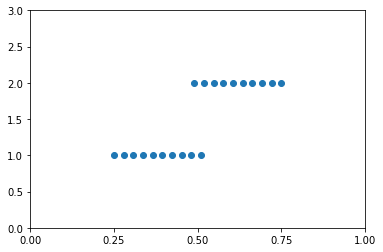

In [103]:
train_X = np.concatenate([np.linspace(0.25,0.51,10), np.linspace(0.49,0.75,10)]).reshape(-1,1)
train_y = np.concatenate([np.ones((10, 1)), np.ones((10, 1))*2])
test_X = np.linspace(0,1,120).reshape(-1,1)
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X, train_y)
plt.ylim(0,3);plt.xticks([0,0.25,0.5,0.75,1]);

In [104]:
# Stationary kernel
def sklearn_gp(K):
  kernel = C() * K + WhiteKernel()
  return GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, random_state=0)
gp = sklearn_gp(RBF())
gp.name = 'sklearn_gp'
print("Stationary kernel=\n", gp.kernel,sep='')

Stationary kernel=
1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)


1.32**2 * RBF(length_scale=1.74) + WhiteKernel(noise_level=0.0711)
16.856471841748668 ->L_theta terms
16.856471816724554 ->L_theta terms
16.856471830314565 ->L_theta terms
16.856471826595154 ->L_theta terms
16.856471785321535 ->L_theta terms
16.856471828276042 ->L_theta terms
16.856471801762556 ->L_theta terms
16.856471761802663 ->L_theta terms
16.856471783951044 ->L_theta terms
1.8558162301820027 ->L_theta terms
1.855816241952406 ->L_theta terms
1.8558163009831312 ->L_theta terms
1.8558162328966916 ->L_theta terms
1.8558162252805297 ->L_theta terms
1.8558162207442117 ->L_theta terms
1.8558162326708314 ->L_theta terms
1.855816226433904 ->L_theta terms
1.8558162068777002 ->L_theta terms
128115578.03438047 ->L_theta terms
128115563.45631339 ->L_theta terms
128025647.1239303 ->L_theta terms
128116519.50226368 ->L_theta terms
128119114.41435543 ->L_theta terms
128112327.20457944 ->L_theta terms
128117995.65320519 ->L_theta terms
128117444.14682645 ->L_theta terms
128118282.52745014 ->L_the

-25.810637608106934 ->L_theta terms
-25.810637870138542 ->L_theta terms
-25.810636426755934 ->L_theta terms
-25.810637152509713 ->L_theta terms
-25.81063723757839 ->L_theta terms
-25.235756637945947 ->L_theta terms
-25.235756617240515 ->L_theta terms
-25.23575647965091 ->L_theta terms
-25.235756776388406 ->L_theta terms
-25.23575717787086 ->L_theta terms
-25.23575670974494 ->L_theta terms
-25.235756832229885 ->L_theta terms
-25.23575673693751 ->L_theta terms
-25.23575704579673 ->L_theta terms
-25.790810691840996 ->L_theta terms
-25.790810669757583 ->L_theta terms
-25.790810595165198 ->L_theta terms
-25.79081055624099 ->L_theta terms
-25.790810194736736 ->L_theta terms
-25.790810138415658 ->L_theta terms
-25.790810117143923 ->L_theta terms
-25.790809788544593 ->L_theta terms
-25.790810794951284 ->L_theta terms
-25.812649971593537 ->L_theta terms
-25.812649949168 ->L_theta terms
-25.812649899553413 ->L_theta terms
-25.81264984620225 ->L_theta terms
-25.812650169389656 ->L_theta terms
-25

-26.45657360944436 ->L_theta terms
-26.45657438939127 ->L_theta terms
-26.456588836300085 ->L_theta terms
-26.45658881403861 ->L_theta terms
-26.456588963591265 ->L_theta terms
-26.456587480557836 ->L_theta terms
-26.456588396731355 ->L_theta terms
-26.456589676062137 ->L_theta terms
-26.456589856775146 ->L_theta terms
-26.45658990934497 ->L_theta terms
-26.456588632771243 ->L_theta terms
-26.456591973464125 ->L_theta terms
-26.45659195120264 ->L_theta terms
-26.456592100759458 ->L_theta terms
-26.456591660511194 ->L_theta terms
-26.4565922029934 ->L_theta terms
-26.456593243505893 ->L_theta terms
-26.456593114115602 ->L_theta terms
-26.456591763385006 ->L_theta terms
-26.4565942651442 ->L_theta terms
-26.456592970402745 ->L_theta terms
-26.456592948141306 ->L_theta terms
-26.456593097698594 ->L_theta terms
-26.456593220832843 ->L_theta terms
-26.456592972416722 ->L_theta terms
-26.456596027966505 ->L_theta terms
-26.456594374108075 ->L_theta terms
-26.45659492302872 ->L_theta terms
-2

-26.626892914949217 ->L_theta terms
-26.62689213611431 ->L_theta terms
-26.626892353763715 ->L_theta terms
-26.62689197439321 ->L_theta terms
-26.626897360705 ->L_theta terms
-26.626897338742772 ->L_theta terms
-26.62689735881252 ->L_theta terms
-26.626894379533802 ->L_theta terms
-26.626896843568336 ->L_theta terms
-26.626896049643783 ->L_theta terms
-26.626896116088822 ->L_theta terms
-26.626895762128065 ->L_theta terms
-26.626895872397263 ->L_theta terms
-26.6268940705944 ->L_theta terms
-26.626894048632185 ->L_theta terms
-26.626894068701482 ->L_theta terms
-26.626894785354658 ->L_theta terms
-26.626894072134178 ->L_theta terms
-26.626894679507224 ->L_theta terms
-26.62689510965783 ->L_theta terms
-26.626894409970667 ->L_theta terms
-26.626895972814623 ->L_theta terms
-26.62689558136598 ->L_theta terms
-26.6268955594036 ->L_theta terms
-26.62689557947337 ->L_theta terms
-26.626896696731663 ->L_theta terms
-26.62689562469427 ->L_theta terms
-26.626895249716537 ->L_theta terms
-26.62

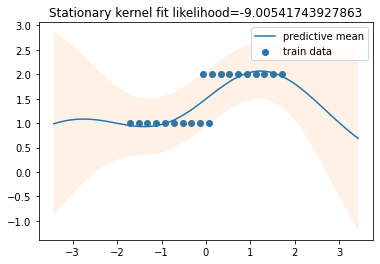

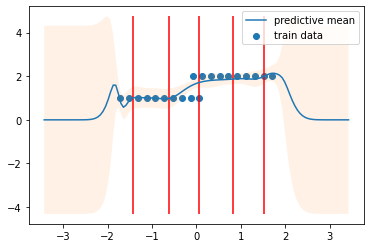

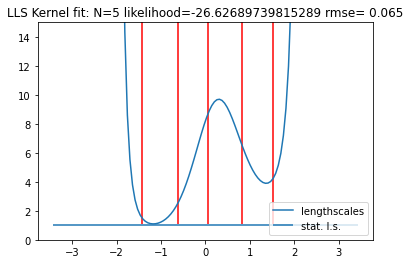

In [105]:
stat_lengthscale = None
def fit_predict_plot(model, title):
  global stat_lengthscale
  plt.figure()
  scaler = StandardScaler()
  train_XX = scaler.fit_transform(train_X)
  test_XX = scaler.transform(test_X)
  model.fit(train_XX, train_y)
  pred_y, pred_cov = model.predict(test_XX, return_cov=True)
  pred_y_train, pred_cov_train = model.predict(train_XX, return_cov=True)
  #print(pred_cov.shape)
  pred_std = (pred_cov.diagonal()**0.5*2).squeeze()
  #print(pred_std)
  plt.scatter(train_XX, train_y, label='train data')
  plt.plot(test_XX, pred_y, label='predictive mean')
  plt.fill_between(test_XX.squeeze(), pred_y.squeeze()-pred_std, pred_y.squeeze()+pred_std, alpha=0.1)
  if model.name == 'LLS':
    plt.vlines(model.X_bar, min(pred_y.squeeze()-pred_std), max(pred_y.squeeze()+pred_std), color='r')
    plt.legend()
    plt.figure()
    pred_l = model.predict_lengthscales(test_XX, model.sigma_l_bar, model.l_bar)
    plt.plot(test_XX, pred_l, label='lengthscales')
    plt.ylim(0,15)
    plt.vlines(model.X_bar, pred_l.min(), pred_l.max(), color='r')
    plt.hlines(stat_lengthscale, test_XX.min(), test_XX.max(), label='stat. l.s.')
    print(model.get_params())
    plt.legend()
    plt.title(title+' likelihood='+str(model.params['likelihood'])+' rmse= '+\
              str(np.round(mean_squared_error(train_y, pred_y_train), 3)))
  else:
    stat_lengthscale = model.get_params()['kernel__k1__k2__length_scale']
    plt.title(title+' likelihood='+str(model.log_marginal_likelihood_value_))
    print(model.kernel_)
  plt.legend()
  globals().update(locals())

fit_predict_plot(gp, 'Stationary kernel fit')
# N =1
# fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
# N =2
# fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
# N =3
# fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
# N =4
# fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =5
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
# N =1000
# fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
"""
{'likelihood': -18.74658632437237, 'global variance': 1.315558809540145, 'noise_level': 0.07106101307486631, 'N_lengthscales': array([[2.45471943]]), 'GP_l_lengthscale': 213.5778593019544}
(120, 120)
{'likelihood': -30.426889662352117, 'global variance': 1.148055746152339, 'noise_level': 0.06751431444337237, 'N_lengthscales': array([[190.05921355],
       [779.02834423]]), 'GP_l_lengthscale': 430.9562051084337}
(120, 120)
{'likelihood': -27.860405229256685, 'global variance': 22.29937552121956, 'noise_level': 0.09312903907578952, 'N_lengthscales': array([[23.24815458],
       [21.94195132],
       [27.83113284]]), 'GP_l_lengthscale': 26.626953651621612}
(120, 120)
{'likelihood': -53.704773206493634, 'global variance': 1.4450989268409948, 'noise_level': 0.06752662151343733, 'N_lengthscales': array([[6.67938726],
       [4.52014274],
       [4.52914645],
       [6.18509496]]), 'GP_l_lengthscale': 15.905839335708256}
(120, 120)
{'likelihood': -61.55468374443657, 'global variance': 1.0752005851469326, 'noise_level': 0.06355292851260301, 'N_lengthscales': array([[2.16341882],
       [2.92787052],
       [1.89067496],
       [2.27732503],
       [2.1797574 ]]), 'GP_l_lengthscale': 7.608834837232022}
"""
1==1;

## Olympic marathon data

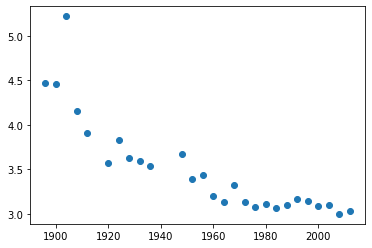

In [72]:
import pods
data = pods.datasets.olympic_marathon_men()
clear_output()
train_X = data['X']
test_X = np.linspace(data['X'].min()-10, data['X'].max()+10, 120).reshape(-1,1)
train_y = data['Y']
plt.scatter(train_X, train_y);

scaler = StandardScaler()
train_XX = scaler.fit_transform(train_X)
nonstat_kernel = lambda n: (C()*LocalLengthScalesKernel.construct(train_XX, l_samples=n)) + WhiteKernel()
def de_optimizer(obj_func, initial_theta, bounds):
      res = differential_evolution(lambda x: obj_func(x, eval_gradient=False),
                                  bounds, maxiter=20, disp=False, polish=False)
      return res.x, obj_func(res.x, eval_gradient=False)
nonstat_gp = lambda n: GaussianProcessRegressor(kernel=nonstat_kernel(n), alpha=1e-5,
                              n_restarts_optimizer=10, random_state=0, optimizer=de_optimizer)

## Testing

5.04**2 * RBF(length_scale=4.28) + WhiteKernel(noise_level=0.0485)
{'likelihood': -9.26535328499943, 'global variance': 5.804964180159348, 'noise_level': 0.09267785661522428, 'N_lengthscales': array([[18.41734616]]), 'GP_l_lengthscale': 4.1521658187630734}
{'likelihood': -10.129332582610896, 'global variance': 3.9399614658418414, 'noise_level': 0.0849476772859076, 'N_lengthscales': array([[1532.26467398],
       [3779.18861879]]), 'GP_l_lengthscale': 4.588404468353855}
{'likelihood': -13.924619464819019, 'global variance': 179.31645652953114, 'noise_level': 0.09851428495271436, 'N_lengthscales': array([[36.80052014],
       [39.50157707],
       [38.43524033]]), 'GP_l_lengthscale': 31.672896032645895}


LinAlgError: Matrix is not positive definite

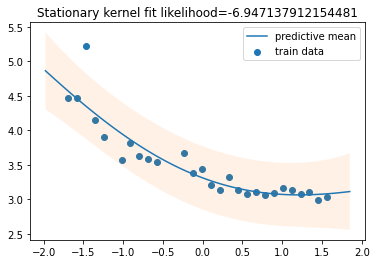

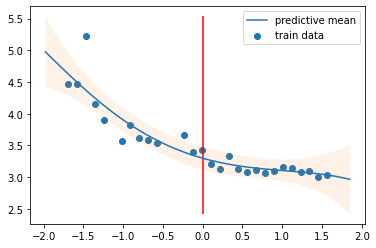

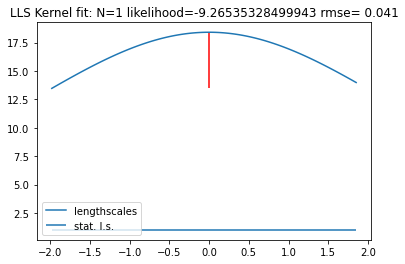

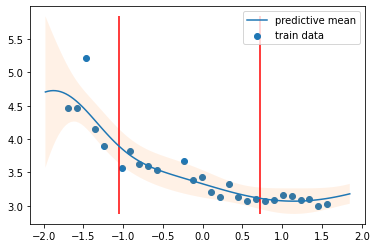

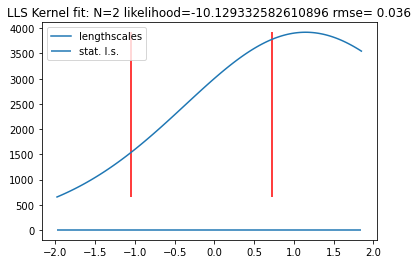

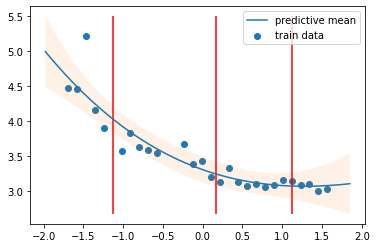

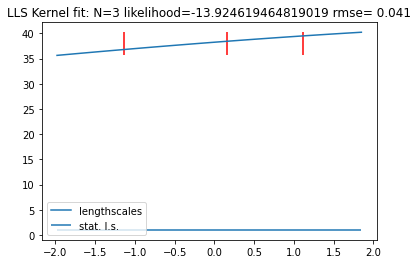

<Figure size 432x288 with 0 Axes>

In [27]:
fit_predict_plot(gp, 'Stationary kernel fit')
N =1
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =2
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =3
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =4
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =5
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
# N =1000
# fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))

## 4 functions joint

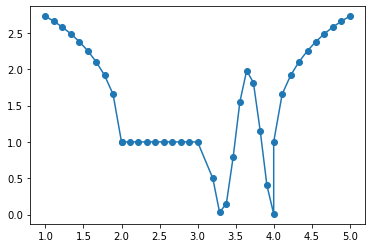

In [10]:
train_X1 = np.linspace(1,2,10);train_X2 = np.linspace(2,3,10);train_X3 = np.linspace(3.2,4,10);train_X4 = np.linspace(4,5,10);
train_y1 = np.sqrt(4-train_X1**2)+1;train_y2 = np.ones(10);train_y3 = np.sin(train_X3*9)+1;train_y4 = np.sqrt(((2)**2)-(train_X1-3)**2)+1;
train_X = np.concatenate([train_X1, train_X2, train_X3, train_X4]).reshape(-1,1)
test_X = np.linspace(0,6,60).reshape(-1,1)
train_y = np.concatenate([train_y1, train_y2, train_y3, train_y4]).reshape(-1,1)
plt.plot(train_X, train_y,'o-');

(60, 60)
3.07**2 * RBF(length_scale=1.89) + WhiteKernel(noise_level=0.193)
(60, 60)
{'likelihood': -9.08255541710762, 'global variance': 2.142200924973774, 'noise_level': 0.18221018283516507, 'N_lengthscales': array([[2.23889442]]), 'GP_l_lengthscale': 1.1879998297466112}
(60, 60)
{'likelihood': -16.854283551872346, 'global variance': 4.578788953315118, 'noise_level': 0.19480702103053318, 'N_lengthscales': array([[16.03071119],
       [38.71763749]]), 'GP_l_lengthscale': 328.5221985396395}
(60, 60)
{'likelihood': -27.15420686412284, 'global variance': 2.606328714441518, 'noise_level': 0.20815179486586602, 'N_lengthscales': array([[2.3508225 ],
       [1.74396926],
       [2.45108308]]), 'GP_l_lengthscale': 41.39300875230217}
(60, 60)
{'likelihood': -31.13499433124984, 'global variance': 19.058559707657054, 'noise_level': 0.19662628025727538, 'N_lengthscales': array([[3.86590884],
       [4.03506054],
       [4.22708618],
       [4.11136851]]), 'GP_l_lengthscale': 12.630388170268047}
(6

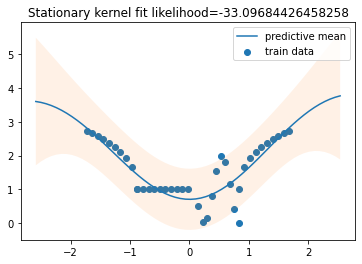

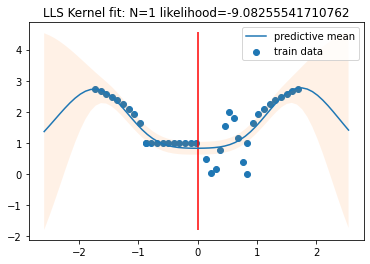

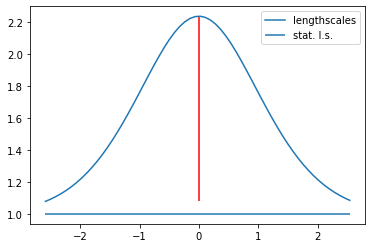

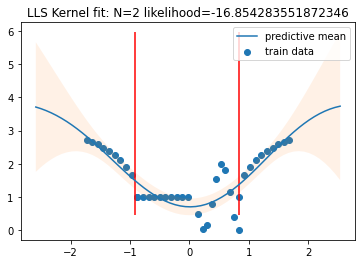

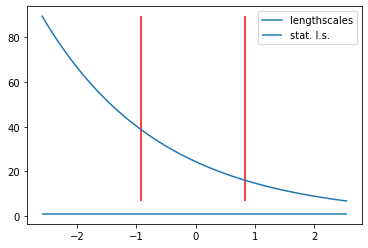

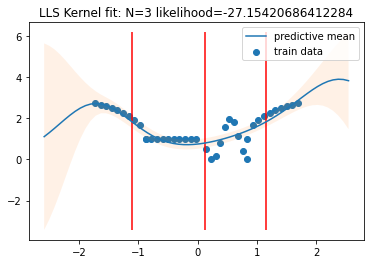

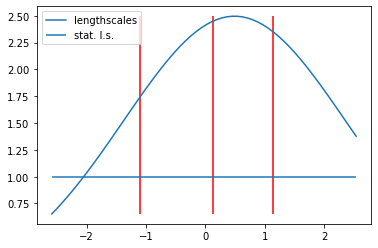

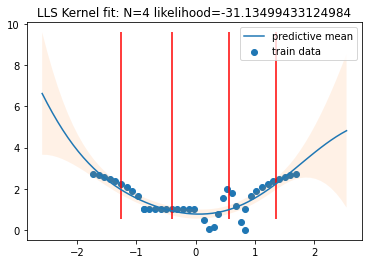

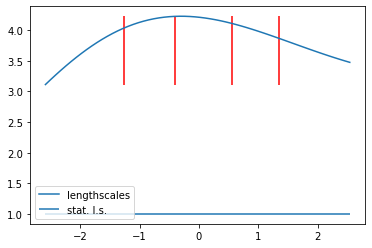

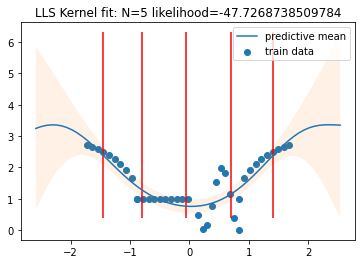

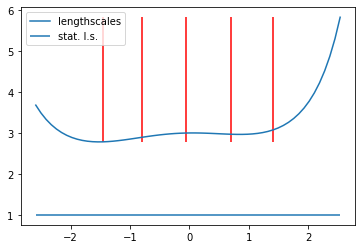

In [11]:
fit_predict_plot(gp, 'Stationary kernel fit')
N =1
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =2
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =3
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =4
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
N =5
fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))
# N =1000
# fit_predict_plot(LLS(N), 'LLS Kernel fit: N='+str(N))

## appendix (random tests)